<a href="https://colab.research.google.com/github/behigu/A-B-test-mlops/blob/main/notebooks/SmartAd_Ad_campaign_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn import metrics
from matplotlib import rcParams
from matplotlib.pyplot import pie, axis, show
from scipy.stats import norm
import xgboost as xgb


In [ ]:
pd.set_option('max_column', None)
df= pd.read_csv('drive/MyDrive/ColabNotebooks/AdSmartABdata.csv')

In [ ]:
df.head(3)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1


In [ ]:
#get the dimension
df.shape

(8077, 9)

In [ ]:
#users who neither said "yes" nor "no"
df[(df.yes == 0)&(df.no == 0)].shape

(6834, 9)

The above output that out of the 8077 users 6834 chose not to respond to the survey, so we will work with those with a valid response.

In [ ]:
#filter users who chose "yes" or "no"
responded = df[(df.yes == 1)|(df.no == 1)].reset_index()
#drop the index from the original dataset
responded.drop('index', axis=1, inplace=True)
responded.shape

(1243, 9)

In [ ]:
#get unique values of each column
responded.nunique()

auction_id     1243
experiment        2
date              8
hour             24
device_make     115
platform_os       2
browser           8
yes               2
no                2
dtype: int64

In [ ]:
def count_plot(variable):
    sns.countplot(x=variable, data=responded)
    
def bar_plot(variable):
    sns.barplot(y=variable, x='yes', data=responded, orient='h')

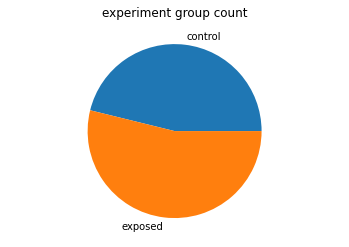

In [ ]:
sums = responded["yes"].groupby(responded.experiment).sum()
plt.title("experiment group count")
axis('equal');
pie(sums, labels=sums.index);
show()

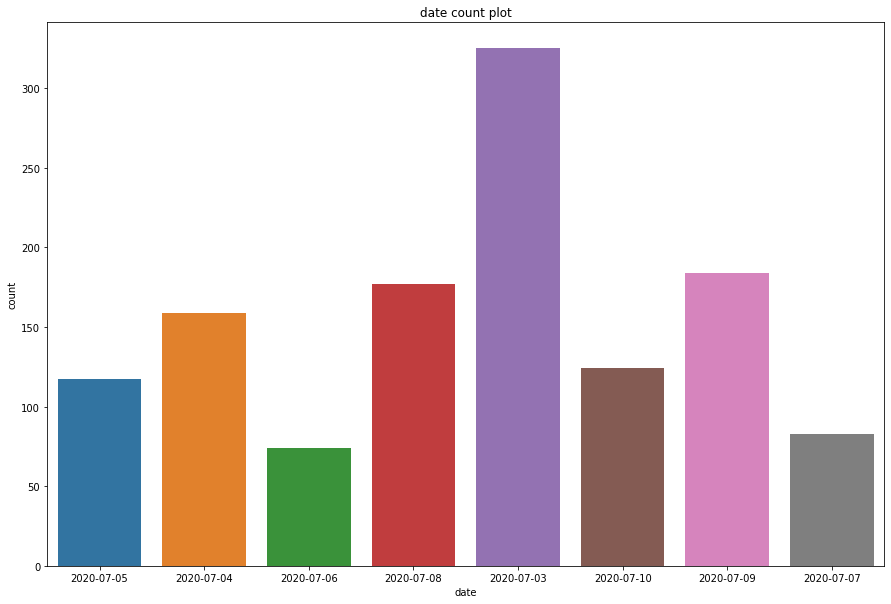

In [ ]:
#plot value counts columns
plt.figure(figsize=(15,10))
plt.title("date count plot")
count_plot( "date")

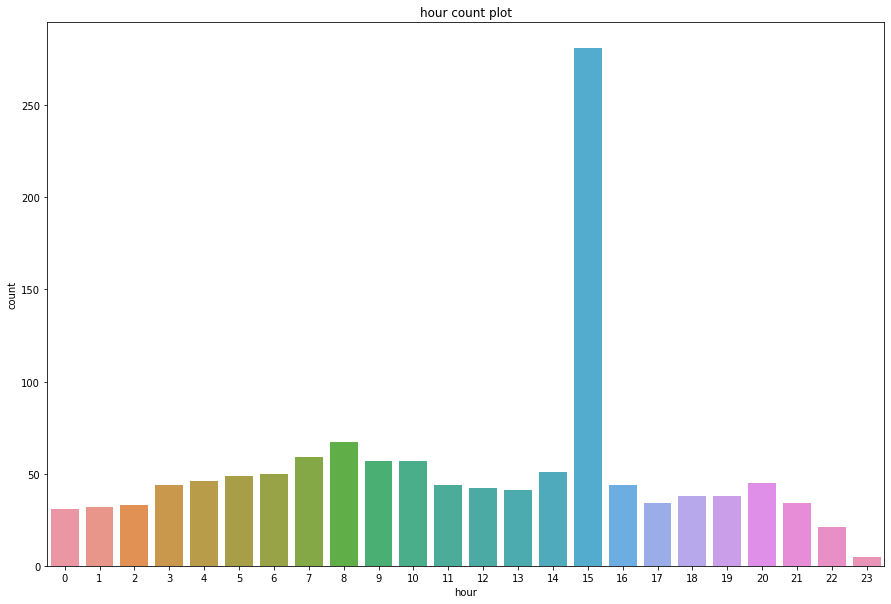

In [ ]:
plt.figure(figsize=(15,10))
plt.title("hour count plot")
count_plot( "hour")

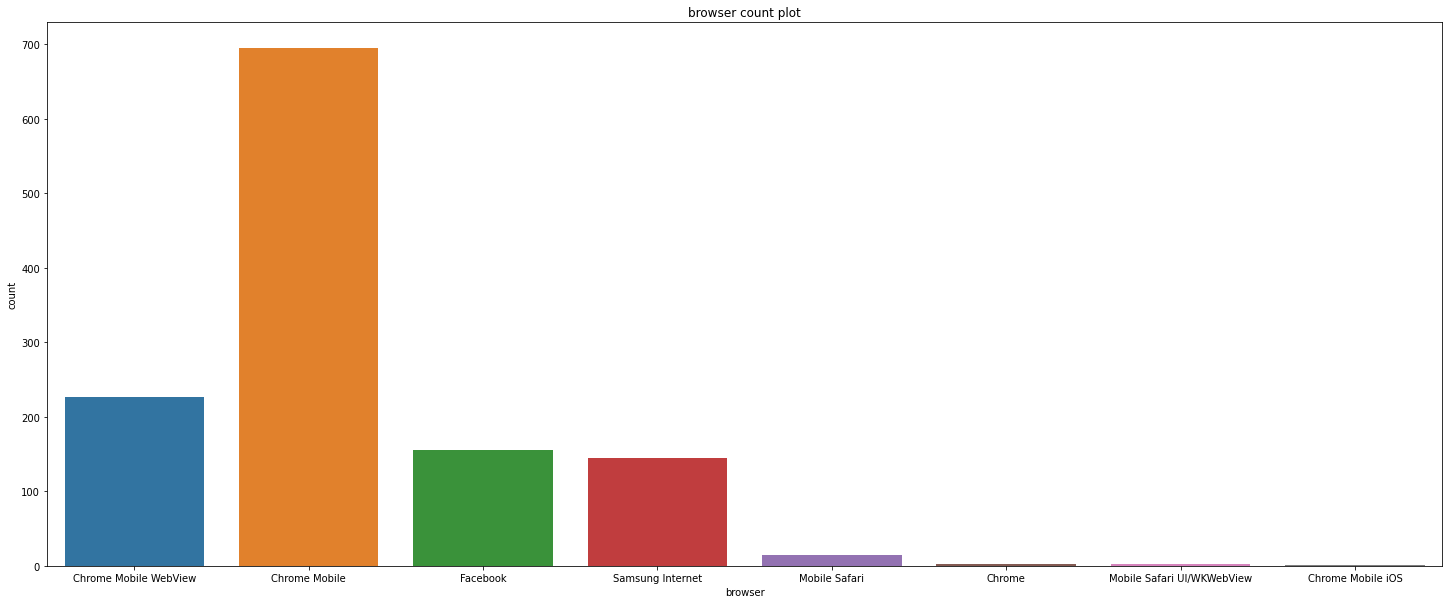

In [ ]:

plt.figure(figsize=(25,10))
plt.title("browser count plot")
count_plot("browser")

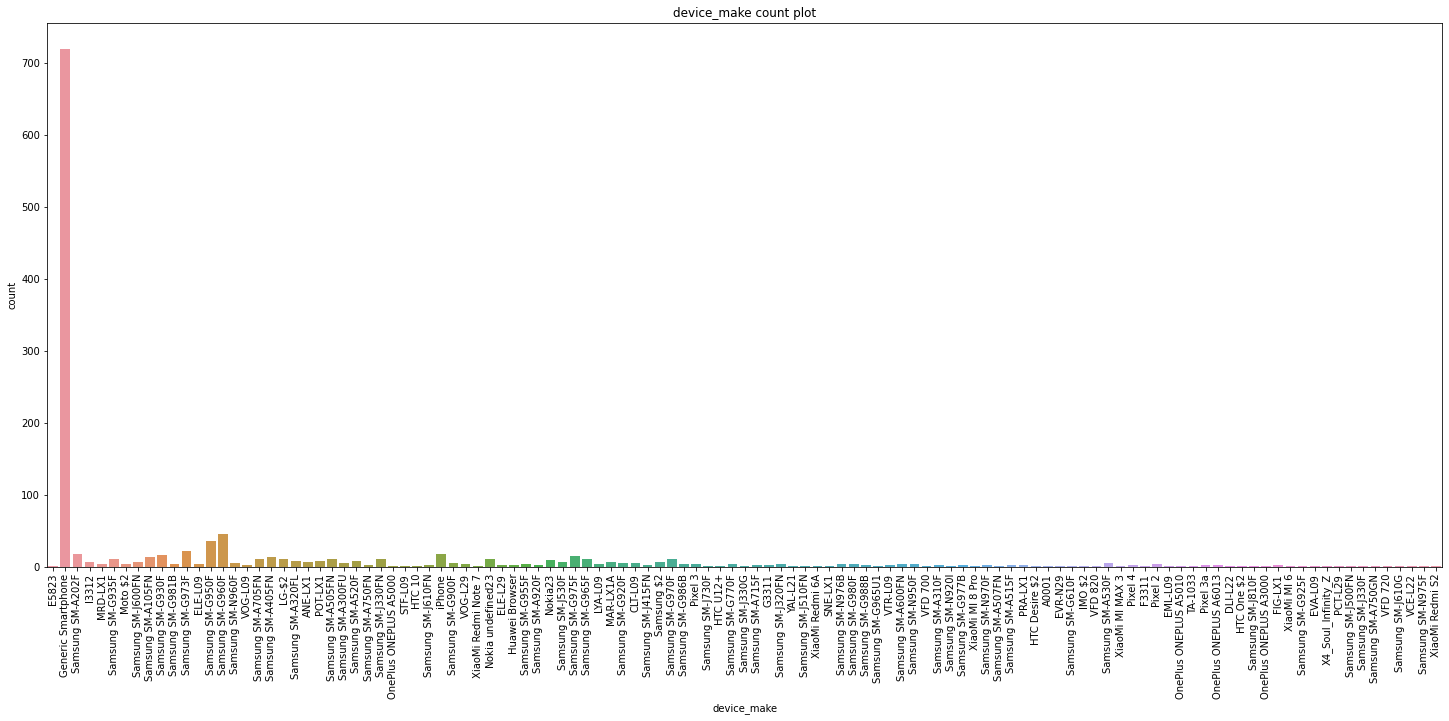

In [ ]:
#rotate x-axis labels 90 degree
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
plt.title("device_make count plot")
count_plot("device_make")

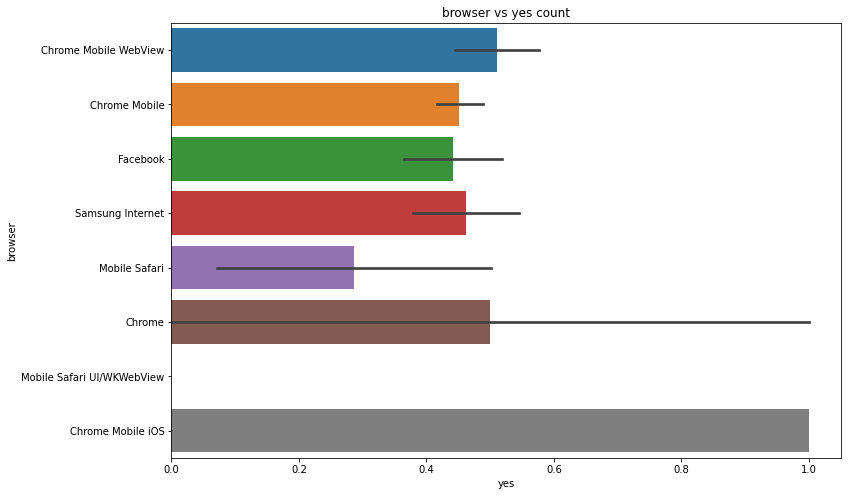

In [ ]:
#The plot below shows the portion of users who said "yes" per browser.
plt.figure(figsize=(12,8))
plt.title("browser vs yes count")
bar_plot('browser')

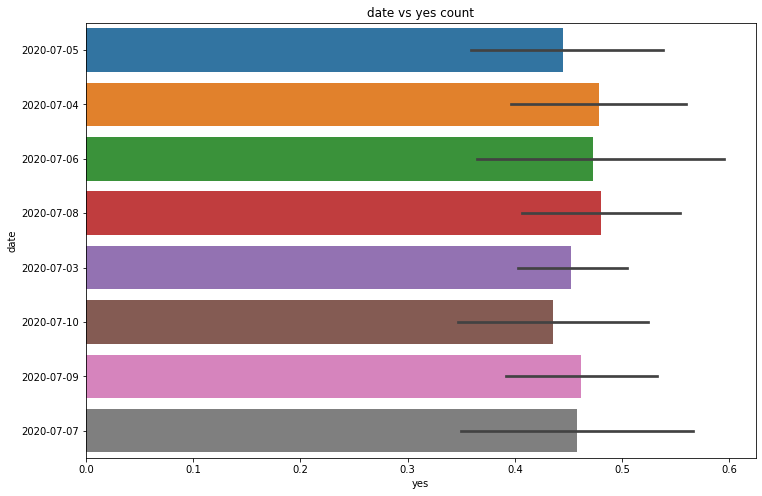

In [ ]:
#The plot below shows the portion of users who said "yes" per date.
plt.figure(figsize=(12,8))
plt.title("date vs yes count")
bar_plot('date')

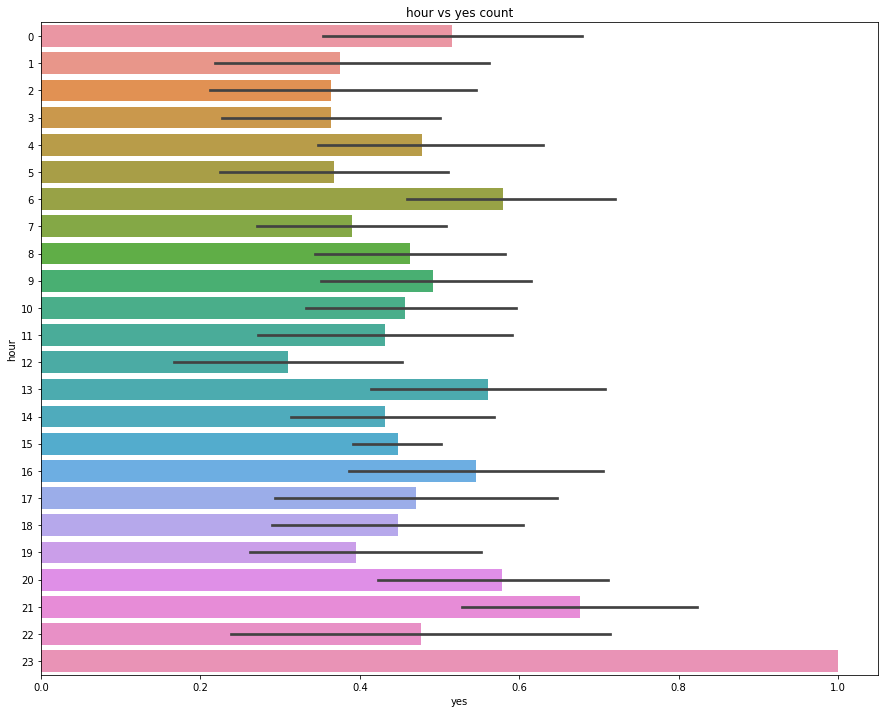

In [ ]:
#The plot below shows the portion of users who said "yes" per hour. It looks users responding at 23:00 o'clock, whatever their number, said "yes"
plt.figure(figsize=(15,12))
plt.title("hour vs yes count")
bar_plot('hour')

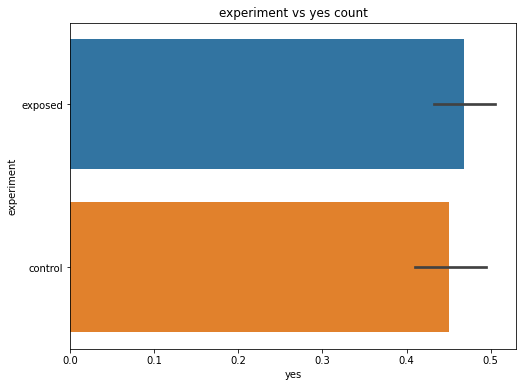

In [ ]:
#In the plot below, we can see that more users in the exposed group said yes than in control group. But we need to rely on the A/B test to confirm this.
plt.figure(figsize=(8,6))
plt.title("experiment vs yes count")
bar_plot('experiment')

In [ ]:
#Part 2: Classical A/B testing

#Let's carry out classical A/B testing by calculating p-vale using statistical tests

#subset of users with id and group only
users = pd.DataFrame(data = responded[["auction_id", "experiment"]])
#add a column for the response
users["converted"] = responded.yes
users.head(4)

,auction_id,experiment,converted
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1


In [ ]:
#separate the control and exposed groups
exposed = users[users.experiment == 'exposed']
control = users[users.experiment == 'control']

In [ ]:
#pivot table to get the sum of converted users in each group
summary = users.pivot_table(values='converted', index='experiment', aggfunc=np.sum)
summary

,converted
experiment,
control,264
exposed,308


In [ ]:
# add additional columns to the pivot table
summary['total'] = users.pivot_table(values='converted', index='experiment', aggfunc=lambda x: len(x))
summary['rate'] = users.pivot_table(values='converted', index='experiment')
summary

,converted,total,rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


In [ ]:
control_converted = summary['converted'][0]
control_total = summary['total'][0]
control_rate = summary['rate'][0]

exposed_converted = summary['converted'][1]
exposed_total = summary['total'][1]
exposed_rate = summary['rate'][1]

rate_difference = exposed_rate-control_rate
rate_difference

0.018285619295484168

Text(0, 0.5, 'probability')

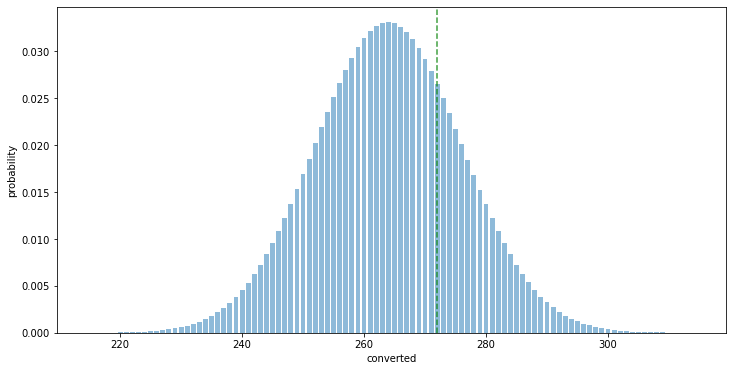

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(summary.iloc[0,0]-49, summary.iloc[0,0]+50, 100)
y = scs.binom(control_total, control_rate).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=exposed_rate*580 , c='green', alpha=0.75, linestyle='--')
#ax.axvline(x=exposed_rate*A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

Text(0, 0.5, 'probability')

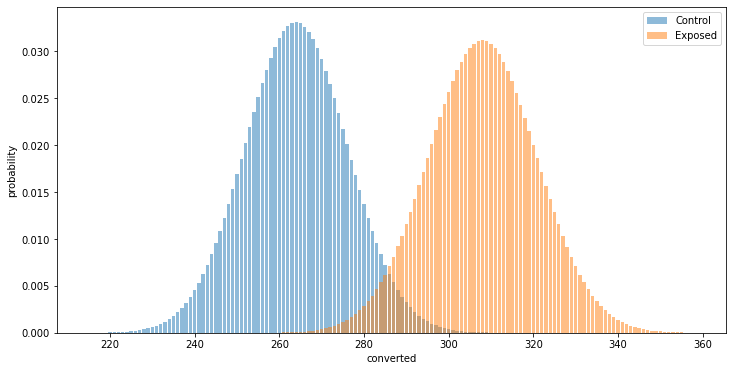

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

xC = np.linspace(control_converted-49, control_converted+50, 100)
yC = scs.binom(control_total, control_rate).pmf(xC)
ax.bar(xC, yC, label = "Control",alpha=0.5)

xE = np.linspace(exposed_converted-49, exposed_converted+50, 100)
yE = scs.binom(exposed_total, exposed_rate).pmf(xE)
ax.bar(xE, yE, label = "Exposed",alpha=0.5)
plt.legend()
plt.xlabel('converted')
plt.ylabel('probability')

In [ ]:
std_C = np.sqrt(ctrl_cr * (1-ctrl_cr)) / np.sqrt(ctrl_total)
std_E = np.sqrt(exposed_rate * (1-exposed_rate)) / np.sqrt(exposed_total)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(ctrl_cr, std_C).pdf(x)
ax.plot(x, yC,label = "Control")
ax.axvline(x=ctrl_cr, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exposed_rate, std_E).pdf(x)
ax.plot(x, yE,label = "Exposed")
ax.axvline(x=exposed_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Converted rate')
plt.ylabel('probablity')

NameError: ignored

In [ ]:
z_score = (rate_difference) / np.sqrt(std_C**2 + std_E**2)
p = norm(rate_difference, np.sqrt(std_C**2 + std_E**2))

x = np.linspace(-0.15, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(exp>ctrl)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

NameError: ignored

In [ ]:
def get_confidence_ab_test(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(control_converted, control_total, exposed_converted, exposed_total))

0.7408273254172715


In [ ]:
def get_p_value(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.sf(z_score)

print(get_p_value(control_converted, control_total, exposed_converted, exposed_total))

0.2591726745827285


In [ ]:
n = 10000
rates_a = norm(control_rate, std_C).rvs(n)
rates_b = norm(exposed_rate, std_E).rvs(n)
b_better = (rates_b > rates_a).sum() /n
print("exposed is better than control {b_better * 100:0.1f}% of the time")

NameError: ignored

In [ ]:
a_dist = np.zeros(control_total)
a_dist[:control_converted] = 1
b_dist = np.zeros(exposed_total)
b_dist[:exposed_converted] = 1
zscore, prob = scs.ttest_ind(a_dist, b_dist, equal_var=True)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -0.65, p-value is 0.519 (two tailed), 0.259 (one tailed)


In [ ]:
sm.stats.ztest(b_dist,a_dist,alternative="larger")

(0.6452687398426953, 0.2593765234051756)

In [ ]:
#a code to calculate sample size (borrowed from github)
def min_sample_size(control_rate, rate_difference, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        control_rate (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        rate_difference (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (control_rate + control_rate+rate_difference) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / rate_difference**2)

    return min_N

In [ ]:
#use the above function to calculate the minimum sample size
min_sample_size(control_rate,rate_difference)

11660.61386940473

Part 3: A/B testing using Machine Learning

Preprocessing and Feature Engineering

In this section we will

1.   take the subset of the data to be modelled
2.   encode categorical variables into numeric variables
3. check the correlation between variables
4. scale the variable
5. check for missing values


In [ ]:
#slice the data removing "auction_id" and "no" columns
ml_data = responded.iloc[:,1:-1]

In [ ]:
# LabelEncoder encodes categorical values into numeric. 
encoder = preprocessing.LabelEncoder() 

# Encode all columns. 
ml_data['experiment']= encoder.fit_transform(ml_data['experiment'])
ml_data['date']= encoder.fit_transform(ml_data['date'])
ml_data['hour']= encoder.fit_transform(ml_data['hour'])
ml_data['device_make']= encoder.fit_transform(ml_data['device_make'])
ml_data['browser']= encoder.fit_transform(ml_data['browser'])
ml_data

,experiment,date,hour,device_make,platform_os,browser,yes
0,1,2,2,4,6,2,0
1,1,1,16,13,6,1,1
2,1,3,8,13,6,1,0
3,0,5,4,43,6,4,1
4,0,0,15,13,6,1,0
...,...,...,...,...,...,...,...
1238,1,2,21,13,6,1,1
1239,1,1,1,13,6,1,1
1240,0,6,7,13,6,1,0
1241,0,7,16,13,6,1,0


In [ ]:
#check if we have sufficient sample size
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   experiment   1243 non-null   int64
 1   date         1243 non-null   int64
 2   hour         1243 non-null   int64
 3   device_make  1243 non-null   int64
 4   platform_os  1243 non-null   int64
 5   browser      1243 non-null   int64
 6   yes          1243 non-null   int64
dtypes: int64(7)
memory usage: 68.1 KB


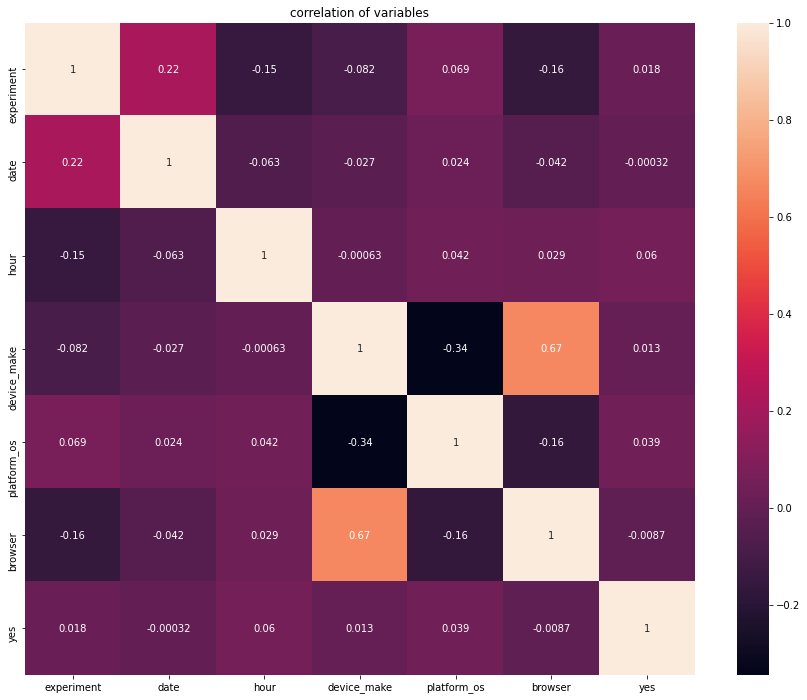

In [ ]:
#get correlation of the variables
correlation = ml_data.corr()
fig, ax = plt.subplots(figsize=(15,12))
plt.title("correlation of variables")
sns.heatmap(correlation, annot=True)
plt.show()

In [ ]:
#The variables are not very correlated, except for browser and device make, so we can drop either of the two. Here, we will drop device make. Let's do Spearmans test before dropping them...
browser = ml_data.browser
device_make = ml_data.device_make
sp_c = spearmanr(browser, device_make)
print(sp_c)

SpearmanrResult(correlation=0.7731806159739668, pvalue=1.0404361256299832e-247)


In [ ]:
#drop device_make column since it is correlated with browser
ml_data.drop("device_make", axis=1, inplace=True)

In [ ]:
#checking for missing values
ml_data.isnull().sum()

experiment     0
date           0
hour           0
platform_os    0
browser        0
yes            0
dtype: int64

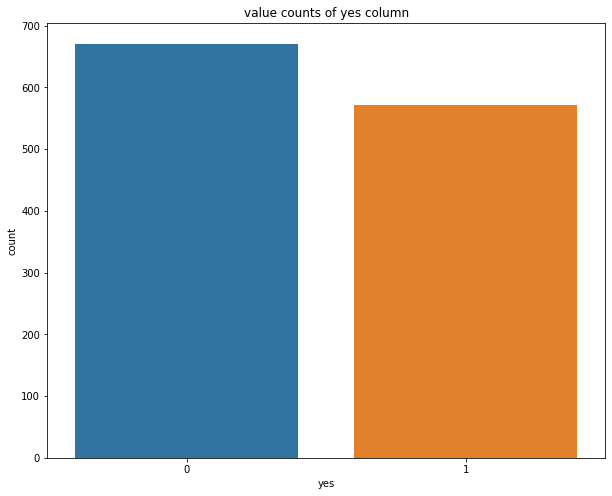

In [ ]:
#MAking sure the target value is binary
fig, ax = plt.subplots(figsize=(10,8))
plt.title("value counts of yes column")
sns.countplot(x = "yes", data=ml_data)

In [ ]:
#nowthe variables are all numeric
ml_data.head(4)

,experiment,date,hour,platform_os,browser,yes
0,1,2,2,6,2,0
1,1,1,16,6,1,1
2,1,3,8,6,1,0
3,0,5,4,6,4,1


In [ ]:
#Scalling the variables to be between 0 and 1
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(ml_data), columns=("experiment","date","hour","platform_os","browser","yes"))
scaled.head(4)

,experiment,date,hour,platform_os,browser,yes
0,1.0,0.285714,0.086957,1.0,0.285714,0.0
1,1.0,0.142857,0.695652,1.0,0.142857,1.0
2,1.0,0.428571,0.347826,1.0,0.142857,0.0
3,0.0,0.714286,0.173913,1.0,0.571429,1.0


In [ ]:
#We now split the data into training, validating and testing sets
#Separate the pridictor and target variables
X = scaled.iloc[:,:-1]
Y = scaled.iloc[:,-1]

In [ ]:
#Use the train_test_split twice to split the data into three groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

# 0.23 x 0.9 = 0.2007
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.23, random_state=1)

In [ ]:
#set our k-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=100)

since all classifiers models can use logarithmic loss function, we can define functions for all models as below.

In [ ]:
#calculate the models loss and returns it
def calculate_loss(model):
    model = model
    # predict probabilities
    probs = model.predict_proba(X_val)
    # keep the predictions for class 1 only
    probs = probs[:, 1]
    # calculate log loss
    loss = log_loss(Y_val, probs)*100
    print("Loss: %.2f"%loss, "%")    

#plots feature importance from the model 
def plot_feature_importance(importance):
    plt.title("feature importance")
    plt.xlabel("features")
    plt.ylabel("importance")
    plt.bar(X_train.columns, importance)
    plt.show()

#returns prediction dataframe using the model
def print_predicted(model):
    prediction = model.predict(X_test)
    predicted_values = pd.DataFrame({"experiment" : X_test.experiment,"actual" : Y_test,"predicted" : prediction})
    return predicted_values

#returns the confusion martix for the model
def confusion_matrix(model):
    prediction = model.predict(X_test)
    return metrics.confusion_matrix(Y_test, prediction)

#returns the mean accuracy of the k-fold iterations
def print_accuracy(model):
    accuracy = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring= 'accuracy').mean()*100
    print("Accuracy: %.2f"%accuracy, "%")

We first use Logistic regression to model the data and see it's accuracy.

In [ ]:
#Use logistic regression from sklearn
log_regression = LogisticRegression()
#fit the training data into the model
log_regression.fit(X_train,Y_train)
#printing the mean accuracy of all iterations of the k-fold
print_accuracy(log_regression)

Accuracy: 55.00 %


In [ ]:
#calculating loss
calculate_loss(log_regression)

Loss: 70.42 %


The model is performing poorly with accuracy 55% and loss 70.42%

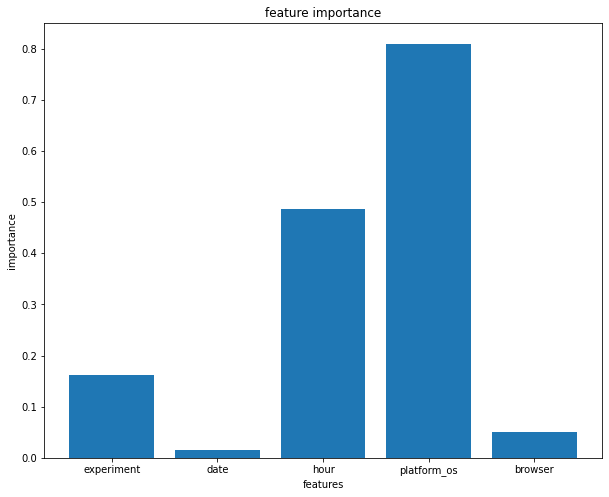

In [ ]:
#plotting feature importance
fig, ax = plt.subplots(figsize=(10,8))
plot_feature_importance(log_regression.coef_[0])

We can observe from the graph that the most important feature is platform_os. Experiment group does not seem to have a significant effect

In [ ]:
#predicted values
print_predicted(log_regression)

,experiment,actual,predicted
616,1.0,1.0,0.0
908,0.0,0.0,0.0
494,1.0,0.0,0.0
571,1.0,1.0,0.0
572,1.0,1.0,1.0
...,...,...,...
88,1.0,0.0,1.0
768,0.0,0.0,0.0
1030,1.0,1.0,0.0
457,0.0,1.0,0.0


In [ ]:
#confusion matrix
confusion_matrix(log_regression)

array([[65,  5],
       [51,  4]])

** Train a Decision tree model to get a better result**

In [ ]:
#instantiate the model from sklearn
d_tree = DecisionTreeClassifier()
#fit the data
d_tree.fit(X_train,Y_train)
#print accuracy
print_accuracy(d_tree)

Accuracy: 51.28 %


In [ ]:
#calculating loss
calculate_loss(d_tree)

Loss: 1101.07 %


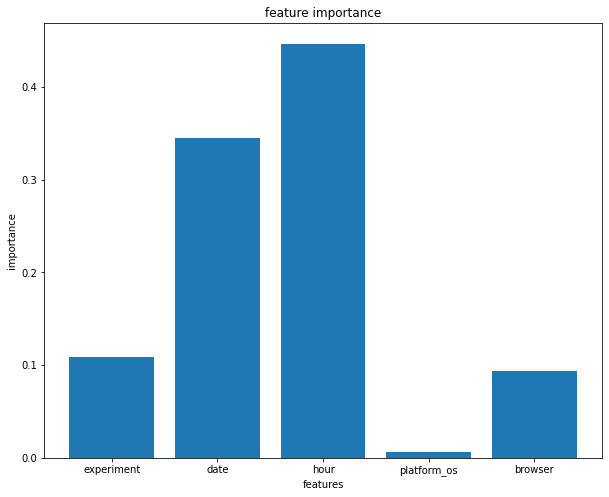

In [ ]:
#plotting feature importance

fig, ax = plt.subplots(figsize=(10,8))
plot_feature_importance(d_tree.feature_importances_)

This model is not doing very good either. In contrary to the previous observation, platform_os has the least effect on the prediction while the date and hour appear to be most important

In [ ]:
#predicted values
print_predicted(d_tree)

,experiment,actual,predicted
616,1.0,1.0,0.0
908,0.0,0.0,0.0
494,1.0,0.0,1.0
571,1.0,1.0,0.0
572,1.0,1.0,0.0
...,...,...,...
88,1.0,0.0,0.0
768,0.0,0.0,0.0
1030,1.0,1.0,0.0
457,0.0,1.0,1.0


In [ ]:
#confusion matrix
confusion_matrix(d_tree)

array([[40, 30],
       [36, 19]])

Let's use an XG Boost model and see if it can perform any better

In [ ]:
#instantiate model
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
xg_boost = xgb.XGBClassifier()
#fit the data
xg_boost.fit(X_train,Y_train)
#print accuracy
print_accuracy(xg_boost)

Accuracy: 51.40 %


In [ ]:
#calculating loss
calculate_loss(xg_boost)

Loss: 72.45 %


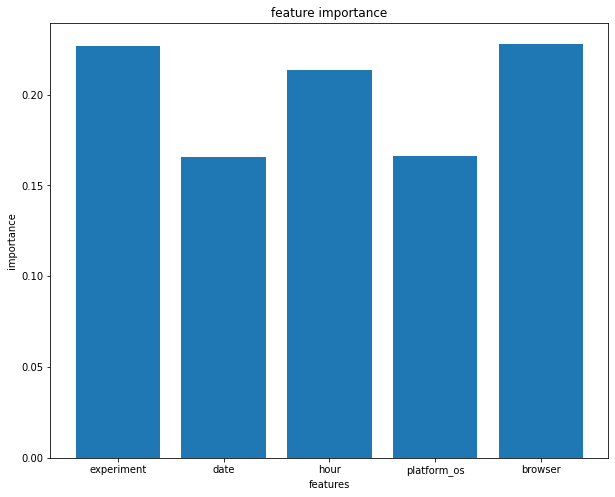

In [ ]:
#plotting feature importance

fig, ax = plt.subplots(figsize=(10,8))
plot_feature_importance(xg_boost.feature_importances_)

The accuracy of this model is similar to the previous models, but it now shows that experiment group is driving the model along with browser type and hour of response

In [ ]:
#predicted values
print_predicted(xg_boost)

,experiment,actual,predicted
616,1.0,1.0,0.0
908,0.0,0.0,0.0
494,1.0,0.0,0.0
571,1.0,1.0,0.0
572,1.0,1.0,0.0
...,...,...,...
88,1.0,0.0,0.0
768,0.0,0.0,0.0
1030,1.0,1.0,1.0
457,0.0,1.0,0.0


In [ ]:
#confusion matrix
confusion_matrix(xg_boost)

array([[49, 21],
       [44, 11]])